In [22]:
import numpy as np

In [23]:
class Node:
    def __init__(self):
        self.rowsWithZero = 0
        self.rank = 0
        self.Ucolumns = None
        self.Vrows = None
        self.eigenvalues = None
        self.children = []

def compress_matrix(A, epsilon, r):
    '''Matrix compression using the SVD algorithm.'''

    v = Node()

    numRows, numCols = A.shape
    submatrices = [
        A[:numRows//2, :numCols//2],
        A[:numRows//2, numCols//2:],
        A[numRows//2:, :numCols//2],
        A[numRows//2:, numCols//2:],
    ]

    for B in submatrices:
        if np.count_nonzero(B) == 0:
            w = Node()
            w.rowsWithZero = B.shape[0]
            w.rank = 0
            v.children.append(w)
        else:
            U, D, Vt = np.linalg.svd(B)

            eigenvalues = np.diag(D)
            k = np.sum(D > epsilon)

            if k == 0:
                w = Node()
                w.rowsWithZero = B.shape[0]
                w.rank = 0
                v.children.append(w)
            elif (k <= r) and ((k < (numRows // 2)) or (k == 1)):
                w = Node()
                w.rank = k
                w.Ucolumns = U[:, :k]
                w.Vrows = Vt[:k, :].transpose()
                w.eigenvalues = eigenvalues[:k, :k]
                w.Vrows = w.Vrows @ w.eigenvalues
                v.children.append(w)
            else:
                w = compress_matrix(B, epsilon, r)
                v.children.append(w)

    return v

A = np.array([[1, 0, 0, 0], [0, 0.3, 0, 0], [1, 0, 0, 6], [0, 0, 0, 0]])
epsilon = 0.01
r = 2

result = compress_matrix(A, epsilon, r)


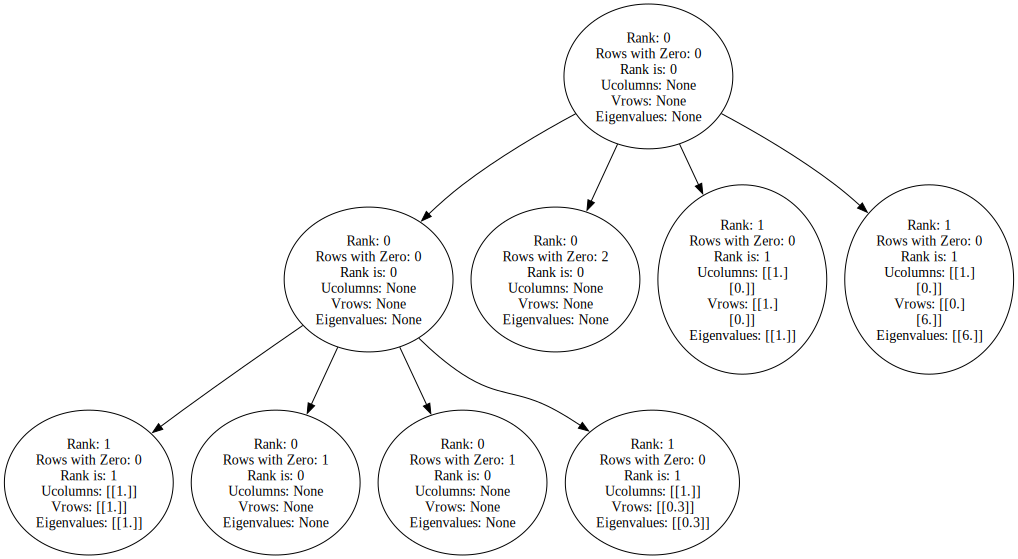

In [24]:
import graphviz
def draw_tree(root):
    ''' Function to draw a tree using graphviz '''
    dot = graphviz.Digraph()

    def traverse(node, parent_id=None):
        node_id = str(id(node))
        label = f"Rank: {node.rank}\nRows with Zero: {node.rowsWithZero}\nRank is: {node.rank}\nUcolumns: {node.Ucolumns}\nVrows: {node.Vrows}\nEigenvalues: {node.eigenvalues}"

        if parent_id is not None:
            dot.edge(parent_id, node_id)

        dot.node(node_id, label)

        for child in node.children:
            traverse(child, node_id)

    traverse(root)
    return dot

draw_tree(result)

In [25]:
def decompress_matrix(node):
    ''' Function to decompress a matrix from a tree'''
    if node.rowsWithZero > 0:
        return np.zeros((node.rowsWithZero, node.rowsWithZero))

    if node.Ucolumns is not None and node.Vrows is not None:
        reconstructed_matrix = np.dot(node.Ucolumns, node.Vrows.transpose())
        return reconstructed_matrix
    else:
        top_left = decompress_matrix(node.children[0])
        top_right = decompress_matrix(node.children[1])
        bottom_left = decompress_matrix(node.children[2])
        bottom_right = decompress_matrix(node.children[3])

        return np.vstack((np.hstack((top_left, top_right)), np.hstack((bottom_left, bottom_right))))

reconstructed_A = decompress_matrix(result)

print("Original Matrix:")
print(A)

print("\nReconstructed Matrix:")
print(reconstructed_A)

Original Matrix:
[[1.  0.  0.  0. ]
 [0.  0.3 0.  0. ]
 [1.  0.  0.  6. ]
 [0.  0.  0.  0. ]]

Reconstructed Matrix:
[[1.  0.  0.  0. ]
 [0.  0.3 0.  0. ]
 [1.  0.  0.  6. ]
 [0.  0.  0.  0. ]]


In [26]:
def test_compression(A, epsilon, r, print_matrices=False):
    ''' Function to test the compression and decompression of a matrix and print nr of differences '''
    result = compress_matrix(A, epsilon, r)
    reconstructed_A = decompress_matrix(result)

    if print_matrices:
        print("Original Matrix:")
        print(A)

        print("\nReconstructed Matrix:")
        print(reconstructed_A)

    nr_of_diffs = np.sum(A-reconstructed_A > epsilon)
    print(f"Number of differences: {nr_of_diffs}")

        

In [27]:
A = np.array([[1, 0.11, 0, 0], [0, 0.3, 0, 0], [1, 0, 0, 6], [0, 0, 0, 1.2]])
epsilon = 0.01
r = 2

test_compression(A, epsilon, r, True)

Original Matrix:
[[1.   0.11 0.   0.  ]
 [0.   0.3  0.   0.  ]
 [1.   0.   0.   6.  ]
 [0.   0.   0.   1.2 ]]

Reconstructed Matrix:
[[1.   0.11 0.   0.  ]
 [0.   0.3  0.   0.  ]
 [1.   0.   0.   6.  ]
 [0.   0.   0.   1.2 ]]
Number of differences: 0


### Tests


In [28]:
def create_matrix_with_zeros(k, percentage_of_zeros):
    ''' Function to create a matrix with a given percentage of zeros '''
    shape = (k, k)

    num_elements = np.prod(shape)

    num_zeros = int(num_elements * percentage_of_zeros)
    num_non_zeros = num_elements - num_zeros

    arr = np.zeros(shape)

    non_zero_indices = np.random.choice(range(num_elements), size=num_non_zeros, replace=False)
    arr[np.unravel_index(non_zero_indices, shape)] = np.random.rand(num_non_zeros)

    return arr



In [29]:
A = create_matrix_with_zeros(k = 2**10,percentage_of_zeros=0.9)
epsilon = 0.01
r = 2**4
test_compression(A, epsilon, r)

Number of differences: 0
